# Applied Data Science Capstone Project

#### Import libraries

In [1]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    brotlipy-0.7.0             |py36h8c4c3a4_1000         346 KB  conda-forge
    chardet-3.0.4              |py36h9f0ad1d_1006         188 KB  conda-forge
    cryptography-3.0           |   py36h45558ae_0         640 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    pandas-1.1.0               |   py36h831f99a_0        10.5 MB  conda-

In [2]:
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.0.0-pyh9f0ad1d_0



geopy-2.0.0          | 63 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: d

In [3]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import json # library to handle JSON files

# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#### Import Austin Neighborhood Data

In [3]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

df_austin = pd.read_csv('austin.csv')
df_austin.head()

the_geom  OBJECTID  GIS_ID  \
0  MULTIPOLYGON (((-97.703804769443 30.3425483142...        61       4   
1  MULTIPOLYGON (((-97.801797691029 30.2015020259...        71     321   
2  MULTIPOLYGON (((-97.752840259002 30.2885458312...        14      49   
3  MULTIPOLYGON (((-97.719629650047 30.3048618108...        46      29   
4  MULTIPOLYGON (((-97.677395295355 30.3516675303...        29      80   

  PLANNING_AREA_NAME NEIGHBORHOOD_PLANNING_STATUS  NEIGHBORHOOD_NUMBER  \
0           HIGHLAND                PLAN APPROVED                   26   
1      GARRISON PARK                PLAN APPROVED                    6   
2    WEST UNIVERSITY                PLAN APPROVED                    7   
3          HYDE PARK                PLAN APPROVED                   74   
4      WINDSOR HILLS                PLAN APPROVED                   91   

  ORDINANCE_NUMBER          DATE_ZONING_APPROVED  \
0     20040513-030  05/13/2004 12:00:00 AM +0000   
1     20141106-085  11/06/2014 12:00:00 AM +0000   
2     20040826-056  08/26/2004 12:00:00 AM +0000   
3     20000413-063  01/31/2002 12:00:00 AM +0000   
4     20110113-059  01/13/2011 12:00:00 AM +0000   

      NEIGHBORHOOD_SUB_DISTRICT  SUBDISTRICT_NUMBER  \
0                          NONE                 NaN   
1            EAST GARRISON PARK                 NaN   
2  WEST UNIVERSITY NEIGHBORHOOD                 NaN   
3                          NONE                 NaN   
4            EAST RUNDBERG LANE                 NaN   

                                COMBINED_NPA COMBINED INFILL_OPTION_CODES  \
0             Brentwood/Highand Combined NPA      YES     SLA/SA/PP/GP/FP   
1                  South Austin Combined NPA      YES     SLA/SA/PP/GP/FP   
2                Central Austin Combined NPA      YES        SLA/PP/GP/FP   
3                                  HYDE PARK       NO                 NaN   
4  Heritage Hills Windsor Hills Combined NPA      YES  SLA/CL/UH/PP/GP/FP   

                                    INTERNET_ADDRESS  CREATED_BY CREATED_DATE  \
0  ftp://ftp.ci.austin.tx.us/npzd/Austingo/brent-...         NaN          NaN   
1  ftp://ftp.ci.austin.tx.us/npzd/Austingo/SACNP_...         NaN          NaN   
2  ftp://ftp.ci.austin.tx.us/npzd/Austingo/ca-com...         NaN          NaN   
3  ftp://ftp.ci.austin.tx.us/npzd/Austingo/hydepa...         NaN          NaN   
4  ftp://ftp.ci.austin.tx.us/npzd/Austingo/hhwh-n...         NaN          NaN   

  MODIFIED_BY MODIFIED_DATE   Shape__Area  Shape__Length  
0         NaN           NaN  7.787902e+06   11236.918410  
1         NaN           NaN  2.122060e+07   18664.879980  
2         NaN           NaN  1.853813e+06    5505.229883  
3         NaN           NaN  2.114746e+07   22268.637590  
4         NaN           NaN  5.006523e+06    9588.858346

#### Clean up Dataframe

In [26]:
df_austin = df_austin[['PLANNING_AREA_NAME']]
df_austin['Latitude'] = ''
df_austin['Longitude'] = ''
df_austin = df_austin.rename(columns={'PLANNING_AREA_NAME':'Neighborhood'})
df_austin.head()

Neighborhood Latitude Longitude
0         HIGHLAND                   
1    GARRISON PARK                   
2  WEST UNIVERSITY                   
3        HYDE PARK                   
4    WINDSOR HILLS

#### Use geolocator to find latitudes and longitudes

In [27]:
hood_num = 0
for hood in df_austin['Neighborhood']:
    
    address = str(hood) + ',' + 'Austin, Tx'
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    if location is None:
        df_austin.loc[hood_num, 'Latitude'] = 0
        df_austin.loc[hood_num, 'Longitude'] = 0
        hood_num = hood_num + 1
    else:
        df_austin.loc[hood_num, 'Latitude'] = location[1][0]
        df_austin.loc[hood_num, 'Longitude'] = location[1][1]
        hood_num = hood_num + 1
    
df_austin.head()

NameError: name 'Nominatim' is not defined

#### Drop duplicate neighborhoods and neighborhoods where no coordinates where found

In [7]:
df_austin = df_austin.drop_duplicates(subset=['Neighborhood'], keep='first')
df_austin = df_austin[df_austin['Latitude'] != 0]
df_austin.reset_index(drop=True,inplace=True)
df_austin.loc[26, 'Latitude'] = 30.393578
df_austin.loc[26, 'Longitude'] = -97.720627
df_austin.head()

Neighborhood Latitude Longitude
0       HIGHLAND  30.3248  -97.7126
1  GARRISON PARK  30.2064  -97.7997
2      HYDE PARK  30.3044  -97.7304
3  WINDSOR HILLS  30.3621  -97.6792
4       CHESTNUT  30.2793  -97.7137

In [69]:
df_austin.shape

(60, 4)

#### Create a map of Austin with Neighborhoods superimposed

In [5]:
address = 'Austin, Tx'

geolocator = Nominatim(user_agent="austin_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [6]:
# create map of Austin using latitude and longitude values
map_austin = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(df_austin['Latitude'], df_austin['Longitude'], df_austin['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_austin)  
    
map_austin

#### Define Foursquare Credentials and Version

In [6]:
CLIENT_ID = '5Y2MVQ20WWYQWA3GRIDNWCYX31EFGIFJXH4EG1XHLLVW0N0N' # your Foursquare ID
CLIENT_SECRET = '2LM5E34DTYPIDBV1FXGAEYFI2CPAVE5J4WGLFFRV0WS0OI5Y' # your Foursquare Secret
VERSION = '20200716'
LIMIT = 100
radius = 1000
section = 'food'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5Y2MVQ20WWYQWA3GRIDNWCYX31EFGIFJXH4EG1XHLLVW0N0N
CLIENT_SECRET:2LM5E34DTYPIDBV1FXGAEYFI2CPAVE5J4WGLFFRV0WS0OI5Y


#### Gather Names and Locations from Foursquare

In [11]:
def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&section={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            section)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['id']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Venue ID']
    
    return(nearby_venues)

In [12]:
austin_venues = getNearbyVenues(names=df_austin['Neighborhood'],
                                   latitudes=df_austin['Latitude'],
                                   longitudes=df_austin['Longitude']
                               )

HIGHLAND
GARRISON PARK
HYDE PARK
WINDSOR HILLS
CHESTNUT
SWEETBRIAR
HERITAGE HILLS
EAST CESAR CHAVEZ
WEST CONGRESS
OLD ENFIELD
WOOTEN
MLK-183
NORTH AUSTIN CIVIC ASSOCIATION
ST. JOHN
CORONADO HILLS
SOUTH MANCHACA
UT
BARTON HILLS
PECAN SPRINGS-SPRINGDALE
CENTRAL EAST AUSTIN
SOUTH RIVER CITY
WINDSOR PARK
PARKER LANE
ST. EDWARDS
ZILKER
BOULDIN CREEK
NORTH BURNET
DAWSON
RIVERSIDE
NORTH SHOAL CREEK
NORTH LOOP
WINDSOR ROAD
ALLANDALE
SOUTHEAST
GEORGIAN ACRES
SOUTH LAMAR
EAST CONGRESS
DOWNTOWN
MLK
MCKINNEY
GATEWAY
NORTH LAMAR
JOHNSTON TERRACE
HANCOCK
ROSEWOOD
EAST OAK HILL
GOVALLE
BRENTWOOD
WEST OAK HILL
ROSEDALE
GALINDO
PLEASANT VALLEY
HOLLY
OLD WEST AUSTIN
FRANKLIN PARK
MONTOPOLIS
UNIVERSITY HILLS
TRIANGLE STATE
CRESTVIEW
WESTGATE


#### Explore Venue Data

In [70]:
print(austin_venues.shape)
austin_venues.head()

(1836, 11)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0     HIGHLAND              30.324836              -97.712608   
1     HIGHLAND              30.324836              -97.712608   
2     HIGHLAND              30.324836              -97.712608   
3     HIGHLAND              30.324836              -97.712608   
4     HIGHLAND              30.324836              -97.712608   

                                   Venue  Venue Latitude  Venue Longitude  \
0                        Vivo Restaurant       30.325447       -97.708553   
1                        Lucky's Puccias       30.329249       -97.709804   
2             Pappadeaux Seafood Kitchen       30.325366       -97.704845   
3                         Arpeggio Grill       30.331051       -97.715317   
4  Cho Sun Gal Bi Korean BBQ & Sushi Bar       30.329763       -97.706639   

              Venue Category                  Venue ID  Rating  Price  \
0         Mexican Restaurant  54483f08498ea61e416adbd9     8.3    1.0   
1                 Food Truck  4c6f1cb7d274b60c11b8d50d     8.4    1.0   
2         Seafood Restaurant  4b1fe27cf964a5203f2a24e3     8.5    1.0   
3  Middle Eastern Restaurant  4a090254f964a5202c741fe3     8.4    1.0   
4          Korean Restaurant  49bfa36df964a52017551fe3     8.6    1.0   

                          Category  
0         Mexican Restaurant : 1.0  
1                 Food Truck : 1.0  
2         Seafood Restaurant : 1.0  
3  Middle Eastern Restaurant : 1.0  
4          Korean Restaurant : 1.0

In [7]:
# create map of Austin using latitude and longitude values
map_austin_venues = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(austin_venues['Neighborhood Latitude'], austin_venues['Neighborhood Longitude'], austin_venues['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='gray',
        fill_opacity=0.7,
        parse_html=False).add_to(map_austin_venues)

# add markers to map
for lat, lng, venue in zip(austin_venues['Venue Latitude'], austin_venues['Venue Longitude'], austin_venues['Venue']):
    label = '{}'.format(venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='red',
        fill=True,
        fill_color='gray',
        fill_opacity=0.7,
        parse_html=False).add_to(map_austin_venues)  
    
map_austin_venues

In [15]:
austin_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  \
Neighborhood                                                                    
ALLANDALE                                          16                      16   
BARTON HILLS                                       22                      22   
BOULDIN CREEK                                      94                      94   
BRENTWOOD                                          31                      31   
CENTRAL EAST AUSTIN                                55                      55   
CHESTNUT                                           30                      30   
CORONADO HILLS                                     15                      15   
CRESTVIEW                                          21                      21   
DAWSON                                             32                      32   
DOWNTOWN                                          100                     100   
EAST CESAR CHAVEZ                                  70                      70   
EAST CONGRESS                                      11                      11   
EAST OAK HILL                                      16                      16   
FRANKLIN PARK                                       5                       5   
GALINDO                                            13                      13   
GARRISON PARK                                      16                      16   
GATEWAY                                            32                      32   
GEORGIAN ACRES                                     13                      13   
GOVALLE                                            23                      23   
HANCOCK                                            35                      35   
HERITAGE HILLS                                      8                       8   
HIGHLAND                                           37                      37   
HOLLY                                              70                      70   
HYDE PARK                                          20                      20   
JOHNSTON TERRACE                                    6                       6   
MCKINNEY                                           12                      12   
MLK                                                13                      13   
MLK-183                                             4                       4   
MONTOPOLIS                                         12                      12   
NORTH AUSTIN CIVIC ASSOCIATION                      5                       5   
NORTH BURNET                                       49                      49   
NORTH LAMAR                                        37                      37   
NORTH LOOP                                         31                      31   
NORTH SHOAL CREEK                                  52                      52   
OLD ENFIELD                                        11                      11   
OLD WEST AUSTIN                                     4                       4   
PARKER LANE                                        25                      25   
PLEASANT VALLEY                                    11                      11   
RIVERSIDE                                         100                     100   
ROSEDALE                                           50                      50   
ROSEWOOD                                           16                      16   
SOUTH LAMAR                                        42                      42   
SOUTH MANCHACA                                      5                       5   
SOUTH RIVER CITY                                   73                      73   
SOUTHEAST                                         100                     100   
ST. EDWARDS                                        33                      33   
ST. JOHN                                           20                      20   
SWEETBRIAR                                         36          

#### Get Venue Ratings and Price Data

In [16]:
austin_venues['Rating'] = ''
austin_venues['Price'] = ''
austin_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0     HIGHLAND              30.324836              -97.712608   
1     HIGHLAND              30.324836              -97.712608   
2     HIGHLAND              30.324836              -97.712608   
3     HIGHLAND              30.324836              -97.712608   
4     HIGHLAND              30.324836              -97.712608   

                                   Venue  Venue Latitude  Venue Longitude  \
0                        Vivo Restaurant       30.325447       -97.708553   
1                        Lucky's Puccias       30.329249       -97.709804   
2             Pappadeaux Seafood Kitchen       30.325366       -97.704845   
3                         Arpeggio Grill       30.331051       -97.715317   
4  Cho Sun Gal Bi Korean BBQ & Sushi Bar       30.329763       -97.706639   

              Venue Category                  Venue ID Rating Price  
0         Mexican Restaurant  54483f08498ea61e416adbd9               
1                 Food Truck  4c6f1cb7d274b60c11b8d50d               
2         Seafood Restaurant  4b1fe27cf964a5203f2a24e3               
3  Middle Eastern Restaurant  4a090254f964a5202c741fe3               
4          Korean Restaurant  49bfa36df964a52017551fe3

In [4]:
# Read in Latest Dataframe Before Making API Calls
austin_venues=pd.read_csv('austin_venues.csv')
df_austin=pd.read_csv('df_austin.csv')
austin_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0     HIGHLAND              30.324836              -97.712608   
1     HIGHLAND              30.324836              -97.712608   
2     HIGHLAND              30.324836              -97.712608   
3     HIGHLAND              30.324836              -97.712608   
4     HIGHLAND              30.324836              -97.712608   

                                   Venue  Venue Latitude  Venue Longitude  \
0                        Vivo Restaurant       30.325447       -97.708553   
1                        Lucky's Puccias       30.329249       -97.709804   
2             Pappadeaux Seafood Kitchen       30.325366       -97.704845   
3                         Arpeggio Grill       30.331051       -97.715317   
4  Cho Sun Gal Bi Korean BBQ & Sushi Bar       30.329763       -97.706639   

              Venue Category                  Venue ID  Rating  Price  \
0         Mexican Restaurant  54483f08498ea61e416adbd9     8.3    1.0   
1                 Food Truck  4c6f1cb7d274b60c11b8d50d     8.4    1.0   
2         Seafood Restaurant  4b1fe27cf964a5203f2a24e3     8.5    2.0   
3  Middle Eastern Restaurant  4a090254f964a5202c741fe3     8.4    1.0   
4          Korean Restaurant  49bfa36df964a52017551fe3     8.6    2.0   

                          Category  
0         Mexican Restaurant : 1.0  
1                 Food Truck : 1.0  
2         Seafood Restaurant : 2.0  
3  Middle Eastern Restaurant : 1.0  
4          Korean Restaurant : 2.0

In [5]:
id_num = 1500

for row in austin_venues.loc[1500:].itertuples():

    for id in austin_venues['Venue ID']:

        venue_id = str(id) 

        # Create API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

        # Make the GET request
        results = requests.get(url).json()['response']['venue']

        if not (results.get('rating') is None):
            austin_venues.loc[id_num, 'Rating'] = results['rating']
        else:
            austin_venues.loc[id_num, 'Rating'] = 0
        if not (results.get('price') is None):
            austin_venues.loc[id_num, 'Price'] = next(iter(results['price'].values()))
            id_num = id_num + 1
        else:
            austin_venues.loc[id_num, 'Price'] = 0
            id_num = id_num + 1
        
austin_venues.head()

KeyError: 'venue'

In [13]:
austin_venues = austin_venues[:1836]
austin_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0     HIGHLAND              30.324836              -97.712608   
1     HIGHLAND              30.324836              -97.712608   
2     HIGHLAND              30.324836              -97.712608   
3     HIGHLAND              30.324836              -97.712608   
4     HIGHLAND              30.324836              -97.712608   

                                   Venue  Venue Latitude  Venue Longitude  \
0                        Vivo Restaurant       30.325447       -97.708553   
1                        Lucky's Puccias       30.329249       -97.709804   
2             Pappadeaux Seafood Kitchen       30.325366       -97.704845   
3                         Arpeggio Grill       30.331051       -97.715317   
4  Cho Sun Gal Bi Korean BBQ & Sushi Bar       30.329763       -97.706639   

              Venue Category                  Venue ID  Rating  Price  
0         Mexican Restaurant  54483f08498ea61e416adbd9     8.3    1.0  
1                 Food Truck  4c6f1cb7d274b60c11b8d50d     8.4    1.0  
2         Seafood Restaurant  4b1fe27cf964a5203f2a24e3     8.5    2.0  
3  Middle Eastern Restaurant  4a090254f964a5202c741fe3     8.4    1.0  
4          Korean Restaurant  49bfa36df964a52017551fe3     8.6    2.0

#### Save Dataframes after each 500 API Calls

In [104]:
austin_venues.to_csv('austin_venues.csv',index=False)

TypeError: get_handle() got an unexpected keyword argument 'errors'

In [100]:
df_austin.to_csv('df_austin.csv',index=False)

TypeError: get_handle() got an unexpected keyword argument 'errors'

#### Combine Venue Category and Price then Clean Dataframe (Go from 4 price tiers to 2)

In [8]:
# Fill in all empty price cells with mode
austin_venues['Price'] = austin_venues['Price'].replace(0.0, np.nan)
austin_venues['Price'] = austin_venues.groupby(['Neighborhood']).Price.apply(lambda x: x.fillna(x.mode()[0]))

# Try only 2 price categories for less options
austin_venues['Price'] = austin_venues['Price'].replace(2.0, 1.0)
austin_venues['Price'] = austin_venues['Price'].replace(3.0, 4.0)
austin_venues['Category'] = austin_venues['Venue Category'].map(str) + ' : ' + austin_venues['Price'].map(str)

austin_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0     HIGHLAND              30.324836              -97.712608   
1     HIGHLAND              30.324836              -97.712608   
2     HIGHLAND              30.324836              -97.712608   
3     HIGHLAND              30.324836              -97.712608   
4     HIGHLAND              30.324836              -97.712608   

                                   Venue  Venue Latitude  Venue Longitude  \
0                        Vivo Restaurant       30.325447       -97.708553   
1                        Lucky's Puccias       30.329249       -97.709804   
2             Pappadeaux Seafood Kitchen       30.325366       -97.704845   
3                         Arpeggio Grill       30.331051       -97.715317   
4  Cho Sun Gal Bi Korean BBQ & Sushi Bar       30.329763       -97.706639   

              Venue Category                  Venue ID  Rating  Price  \
0         Mexican Restaurant  54483f08498ea61e416adbd9     8.3    1.0   
1                 Food Truck  4c6f1cb7d274b60c11b8d50d     8.4    1.0   
2         Seafood Restaurant  4b1fe27cf964a5203f2a24e3     8.5    1.0   
3  Middle Eastern Restaurant  4a090254f964a5202c741fe3     8.4    1.0   
4          Korean Restaurant  49bfa36df964a52017551fe3     8.6    1.0   

                          Category  
0         Mexican Restaurant : 1.0  
1                 Food Truck : 1.0  
2         Seafood Restaurant : 1.0  
3  Middle Eastern Restaurant : 1.0  
4          Korean Restaurant : 1.0

#### Group by Neighborhood and then Category and get Average Ratings

In [9]:
austin_venues1 = austin_venues[['Neighborhood','Category','Rating']]
austin_group = austin_venues1.groupby(['Neighborhood','Category']).mean()
austin_group = austin_group.reset_index()
austin_group.head()

Neighborhood                    Category  Rating
0    ALLANDALE                  Café : 1.0    8.30
1    ALLANDALE  Fast Food Restaurant : 1.0    4.25
2    ALLANDALE            Food Stand : 1.0    8.60
3    ALLANDALE            Food Truck : 1.0    5.50
4    ALLANDALE   Fried Chicken Joint : 1.0    8.90

In [10]:
austin_t = austin_group.pivot(index='Neighborhood', columns='Category', values='Rating')
austin_t = austin_t.reset_index()
austin_t = austin_t.fillna(0)

austin_t.head()

Category         Neighborhood  African Restaurant : 1.0  \
0                   ALLANDALE                       0.0   
1                BARTON HILLS                       0.0   
2               BOULDIN CREEK                       6.9   
3                   BRENTWOOD                       0.0   
4         CENTRAL EAST AUSTIN                       0.0   

Category  American Restaurant : 1.0  American Restaurant : 4.0  \
0                              0.00                        0.0   
1                              0.00                        0.0   
2                              0.00                        0.0   
3                              8.30                        0.0   
4                              6.65                        0.0   

Category  Argentinian Restaurant : 1.0  Asian Restaurant : 1.0  \
0                                  0.0                     0.0   
1                                  0.0                     0.0   
2                                  0.0                     6.8   
3                                  0.0                     5.8   
4                                  0.0                     0.0   

Category  Asian Restaurant : 4.0  BBQ Joint : 1.0  BBQ Joint : 4.0  \
0                            0.0             0.00              0.0   
1                            0.0             0.00              0.0   
2                            0.0             7.60              6.8   
3                            0.0             0.00              0.0   
4                            0.0             8.25              0.0   

Category  Bagel Shop : 1.0  ...  Tapas Restaurant : 1.0  \
0                      0.0  ...                     0.0   
1                      0.0  ...                     0.0   
2                      0.0  ...                     0.0   
3                      0.0  ...                     0.0   
4                      8.8  ...                     0.0   

Category  Tapas Restaurant : 4.0  Tex-Mex Restaurant : 1.0  \
0                            0.0                       0.0   
1                            7.3                       8.4   
2                            0.0                       0.0   
3                            0.0                       0.0   
4                            0.0                       0.0   

Category  Thai Restaurant : 1.0  Thai Restaurant : 4.0  \
0                           0.0                    0.0   
1                           0.0                    0.0   
2                           0.0                    9.1   
3                           0.0                    0.0   
4                           0.0                    0.0   

Category  Turkish Restaurant : 1.0  Vegetarian / Vegan Restaurant : 1.0  \
0                              0.0                                 0.00   
1                              0.0                                 8.30   
2                              0.0                                 5.90   
3                              0.0                                 0.00   
4                              8.2                                 7.35   

Category  Vegetarian / Vegan Restaurant : 4.0  Vietnamese Restaurant : 1.0  \
0                                         0.0                          0.0   
1                                         0.0                          0.0   
2                                         0.0                          6.6   
3                                         0.0                          0.0   
4                                         0.0                          0.0   

Category  Wings Joint : 1.0  
0                       0.0  
1                       0.0  
2                       0.0  
3                       0.0  
4                       0.0  

[5 rows x 119 columns]

#### Create Function to sort in Ascending Order then Find Top Categories in Each Neighborhood

In [11]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [12]:
num_top_venues = 4

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Ranked Category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Ranked Category'.format(ind+1))

# create a new dataframe
austin_sorted = pd.DataFrame(columns=columns)
austin_sorted['Neighborhood'] = austin_t['Neighborhood']

for ind in np.arange(austin_t.shape[0]):
    austin_sorted.iloc[ind, 1:] = return_most_common_venues(austin_t.iloc[ind, :], num_top_venues)

austin_sorted.head()

Neighborhood        1st Ranked Category  \
0            ALLANDALE  Fried Chicken Joint : 1.0   
1         BARTON HILLS           Taco Place : 1.0   
2        BOULDIN CREEK   Italian Restaurant : 4.0   
3            BRENTWOOD    Korean Restaurant : 1.0   
4  CENTRAL EAST AUSTIN           Bagel Shop : 1.0   

              2nd Ranked Category        3rd Ranked Category  \
0                Food Stand : 1.0                 Café : 1.0   
1            Sandwich Place : 1.0   Tex-Mex Restaurant : 1.0   
2           Thai Restaurant : 4.0   Mexican Restaurant : 4.0   
3            Sandwich Place : 4.0  American Restaurant : 1.0   
4  Mediterranean Restaurant : 1.0       Breakfast Spot : 1.0   

                   4th Ranked Category  
0                     Food Truck : 1.0  
1  Vegetarian / Vegan Restaurant : 1.0  
2                           Café : 1.0  
3             Mexican Restaurant : 1.0  
4             Seafood Restaurant : 1.0

#### KMeans Clustering

In [13]:
# Find Optimal k
from sklearn.cluster import KMeans

austin_clust = austin_t.drop('Neighborhood', 1)

Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(austin_clust)
    Sum_of_squared_distances.append(km.inertia_)

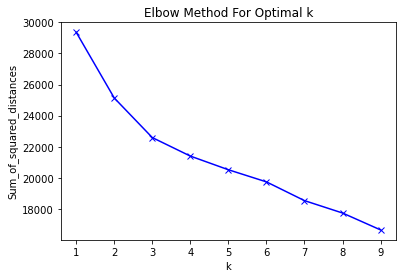

In [14]:
import matplotlib.pyplot as plt

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [15]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(austin_clust)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

array([0, 1, 1, 1, 3, 1, 0, 0, 1, 1, 3, 0, 0, 0, 0, 0, 1, 0, 0, 3],
      dtype=int32)

In [16]:
# add clustering labels
austin_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
austin_merged = df_austin

# merge to add latitude/longitude for each neighborhood
austin_merged = austin_merged.join(austin_sorted.set_index('Neighborhood'), on='Neighborhood')

# clean dataframe
del austin_merged['Unnamed: 0']
austin_merged.drop(18, inplace = True)
austin_merged.reset_index(drop = True, inplace = True)
austin_merged['Cluster Labels'] = austin_merged['Cluster Labels'].astype(int)

austin_merged.head()

Neighborhood   Latitude  Longitude  Cluster Labels  \
0       HIGHLAND  30.324836 -97.712608               0   
1  GARRISON PARK  30.206373 -97.799747               0   
2      HYDE PARK  30.304412 -97.730448               1   
3  WINDSOR HILLS  30.362072 -97.679214               0   
4       CHESTNUT  30.279257 -97.713717               1   

               1st Ranked Category       2nd Ranked Category  \
0  Middle Eastern Restaurant : 1.0          Food Truck : 1.0   
1         Seafood Restaurant : 1.0  Chinese Restaurant : 1.0   
2                     Bakery : 1.0                Café : 4.0   
3       Fast Food Restaurant : 1.0  Mexican Restaurant : 1.0   
4         Italian Restaurant : 1.0          Restaurant : 1.0   

              3rd Ranked Category         4th Ranked Category  
0              Burger Joint : 1.0    Mexican Restaurant : 1.0  
1            Sandwich Place : 1.0           Pizza Place : 1.0  
2  Mediterranean Restaurant : 1.0   American Restaurant : 1.0  
3               Wings Joint : 1.0  Fast Food Restaurant : 4.0  
4       American Restaurant : 1.0        Sandwich Place : 1.0

#### Cluster 1

In [17]:
austin_merged.loc[austin_merged['Cluster Labels'] == 0, austin_merged.columns[[0] + list(range(4, austin_merged.shape[1]))]]

Neighborhood              1st Ranked Category  \
0                         HIGHLAND  Middle Eastern Restaurant : 1.0   
1                    GARRISON PARK         Seafood Restaurant : 1.0   
3                    WINDSOR HILLS       Fast Food Restaurant : 1.0   
5                       SWEETBRIAR           Sushi Restaurant : 1.0   
6                   HERITAGE HILLS                 Donut Shop : 1.0   
8                    WEST CONGRESS         Mexican Restaurant : 1.0   
9                      OLD ENFIELD                       Café : 4.0   
11                         MLK-183             Sandwich Place : 1.0   
12  NORTH AUSTIN CIVIC ASSOCIATION      Vietnamese Restaurant : 1.0   
13                        ST. JOHN                 Donut Shop : 1.0   
14                  CORONADO HILLS  South American Restaurant : 1.0   
15                  SOUTH MANCHACA                 Taco Place : 1.0   
20                    WINDSOR PARK                 Restaurant : 4.0   
22                     ST. EDWARDS                      Diner : 1.0   
30                    WINDSOR ROAD                 Food Truck : 1.0   
31                       ALLANDALE        Fried Chicken Joint : 1.0   
33                  GEORGIAN ACRES         Chinese Restaurant : 1.0   
35                   EAST CONGRESS                 Food Truck : 1.0   
38                        MCKINNEY       Fast Food Restaurant : 4.0   
40                     NORTH LAMAR  Middle Eastern Restaurant : 1.0   
41                JOHNSTON TERRACE               Burger Joint : 1.0   
44                   EAST OAK HILL        American Restaurant : 1.0   
45                         GOVALLE       Fast Food Restaurant : 1.0   
47                   WEST OAK HILL                Wings Joint : 1.0   
49                         GALINDO                Pizza Place : 1.0   
50                 PLEASANT VALLEY                 Food Truck : 1.0   
52                 OLD WEST AUSTIN                 Food Truck : 1.0   
53                   FRANKLIN PARK                       Food : 1.0   
54                      MONTOPOLIS                 Donut Shop : 4.0   
55                UNIVERSITY HILLS                 Restaurant : 1.0   
57                       CRESTVIEW                     Bakery : 1.0   
58                        WESTGATE             Sandwich Place : 1.0   

              2nd Ranked Category              3rd Ranked Category  \
0                Food Truck : 1.0               Burger Joint : 1.0   
1        Chinese Restaurant : 1.0             Sandwich Place : 1.0   
3        Mexican Restaurant : 1.0                Wings Joint : 1.0   
5        Chinese Restaurant : 1.0                Wings Joint : 1.0   
6            Sandwich Place : 1.0                Pizza Place : 1.0   
8                Food Truck : 1.0                 Taco Place : 1.0   
9       American Restaurant : 4.0        American Restaurant : 1.0   
11              Wings Joint : 1.0           Cuban Restaurant : 1.0   
12               Taco Place : 1.0        Filipino Restaurant : 1.0   
13  Comfort Food Restaurant : 1.0  South American Restaurant : 1.0   
14     Fast Food Restaurant : 1.0           Asian Restaurant : 1.0   
15     Fast Food Restaurant : 1.0         Mexican Restaurant : 1.0   
20                     Café : 1.0                Pizza Place : 1.0   
22               Food Truck : 1.0                  BBQ Joint : 1.0   
30              Wings Joint : 1.0        Filipino Restaurant : 1.0   
31               Food Stand : 1.0                       Café : 1.0   
33             Burger Joint : 1.0         Seafood Restaurant : 1.0   
35               Taco Place : 4.0                 Restaurant : 1.0   
38       Mexican Restaurant : 1.0                 Food Truck : 1.0   
40               Food Truck : 1.0                Wings Joint : 1.0   
41       Mexican Restaurant : 1.0                 Food Truck : 1.0   
44                     Café : 1.0             Sandwich Place : 1.0   
45                   Bakery : 1.0                 Food Truck : 1.0  

#### Cluster 2

In [18]:
austin_merged.loc[austin_merged['Cluster Labels'] == 1, austin_merged.columns[[0] + list(range(4, austin_merged.shape[1]))]]

Neighborhood            1st Ranked Category  \
2           HYDE PARK                   Bakery : 1.0   
4            CHESTNUT       Italian Restaurant : 1.0   
10             WOOTEN         Ramen Restaurant : 1.0   
17       BARTON HILLS               Taco Place : 1.0   
19   SOUTH RIVER CITY        Indian Restaurant : 1.0   
21        PARKER LANE              Pizza Place : 1.0   
23             ZILKER         Ramen Restaurant : 1.0   
24      BOULDIN CREEK       Italian Restaurant : 4.0   
25       NORTH BURNET         Asian Restaurant : 1.0   
26             DAWSON                     Café : 4.0   
28  NORTH SHOAL CREEK  Comfort Food Restaurant : 1.0   
29         NORTH LOOP               Food Truck : 4.0   
34        SOUTH LAMAR               Food Truck : 4.0   
36           DOWNTOWN             Noodle House : 1.0   
37                MLK             Burger Joint : 4.0   
39            GATEWAY       Italian Restaurant : 4.0   
43           ROSEWOOD               Restaurant : 1.0   
46          BRENTWOOD        Korean Restaurant : 1.0   
48           ROSEDALE       Italian Restaurant : 4.0   
56     TRIANGLE STATE      Japanese Restaurant : 4.0   

          2nd Ranked Category              3rd Ranked Category  \
2                  Café : 4.0   Mediterranean Restaurant : 1.0   
4            Restaurant : 1.0        American Restaurant : 1.0   
10         Burger Joint : 1.0                 Steakhouse : 4.0   
17       Sandwich Place : 1.0         Tex-Mex Restaurant : 1.0   
19           Taco Place : 4.0            Thai Restaurant : 4.0   
21         Burger Joint : 1.0           Asian Restaurant : 1.0   
23    Korean Restaurant : 1.0        Japanese Restaurant : 1.0   
24      Thai Restaurant : 4.0         Mexican Restaurant : 4.0   
25            Cafeteria : 1.0         Seafood Restaurant : 1.0   
26     Cuban Restaurant : 4.0        Hawaiian Restaurant : 1.0   
28  Japanese Restaurant : 1.0                 Bagel Shop : 1.0   
29               Bakery : 1.0             Sandwich Place : 1.0   
34          Pizza Place : 1.0              Deli / Bodega : 1.0   
36                 Café : 4.0  Cajun / Creole Restaurant : 1.0   
37               Bakery : 4.0        American Restaurant : 4.0   
39  American Restaurant : 1.0         Italian Restaurant : 1.0   
43        Deli / Bodega : 1.0         Mexican Restaurant : 1.0   
46       Sandwich Place : 4.0        American Restaurant : 1.0   
48  Japanese Restaurant : 1.0                       Café : 1.0   
56         Burger Joint : 1.0     Gluten-free Restaurant : 1.0   

                    4th Ranked Category  
2             American Restaurant : 1.0  
4                  Sandwich Place : 1.0  
10                 Sandwich Place : 1.0  
17  Vegetarian / Vegan Restaurant : 1.0  
19               Asian Restaurant : 1.0  
21             Mexican Restaurant : 1.0  
23               Tapas Restaurant : 1.0  
24                           Café : 1.0  
25      Latin American Restaurant : 1.0  
26                     Food Truck : 1.0  
28                     Steakhouse : 1.0  
29                    Pizza Place : 1.0  
34                     Taco Place : 1.0  
36                       Creperie : 1.0  
37             Seafood Restaurant : 1.0  
39                     Taco Place : 1.0  
43                         Bistro : 1.0  
46             Mexican Restaurant : 1.0  
48            American Restaurant : 1.0  
56             Italian Restaurant : 1.0

#### Cluster 3

In [19]:
austin_merged.loc[austin_merged['Cluster Labels'] == 2, austin_merged.columns[[0] + list(range(4, austin_merged.shape[1]))]]

Neighborhood  1st Ranked Category 2nd Ranked Category  \
16           UT  Deli / Bodega : 1.0    Restaurant : 4.0   
27    RIVERSIDE     Bagel Shop : 1.0          Café : 4.0   

         3rd Ranked Category       4th Ranked Category  
16  Seafood Restaurant : 4.0  Israeli Restaurant : 1.0  
27  Chinese Restaurant : 1.0      Sandwich Place : 1.0

#### Cluster 4

In [20]:
austin_merged.loc[austin_merged['Cluster Labels'] == 3, austin_merged.columns[[0] + list(range(4, austin_merged.shape[1]))]]

Neighborhood                    1st Ranked Category  \
7     EAST CESAR CHAVEZ  Southern / Soul Food Restaurant : 1.0   
18  CENTRAL EAST AUSTIN                       Bagel Shop : 1.0   
32            SOUTHEAST              Japanese Restaurant : 1.0   
42              HANCOCK    Vegetarian / Vegan Restaurant : 1.0   
51                HOLLY                   Breakfast Spot : 1.0   

               2nd Ranked Category             3rd Ranked Category  \
7                       Café : 1.0          Ramen Restaurant : 1.0   
18  Mediterranean Restaurant : 1.0            Breakfast Spot : 1.0   
32                 Irish Pub : 1.0               Pizza Place : 1.0   
42             Deli / Bodega : 1.0  Mediterranean Restaurant : 1.0   
51        Seafood Restaurant : 1.0   New American Restaurant : 1.0   

                      4th Ranked Category  
7                 Indian Restaurant : 1.0  
18               Seafood Restaurant : 1.0  
32        Latin American Restaurant : 4.0  
42                       Restaurant : 1.0  
51  Southern / Soul Food Restaurant : 1.0

In [21]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(austin_merged['Latitude'], austin_merged['Longitude'], austin_merged['Neighborhood'], austin_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ': Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

#### Try Groupby with the Clusters to get Average Rating for Each Category

In [22]:
austin_t.replace(0, np.nan, inplace = True)
austin_t.insert(0, 'Cluster Labels', kmeans.labels_)
austin_t = austin_t.drop('Neighborhood', 1)
austin_t.head()

Category  Cluster Labels  African Restaurant : 1.0  American Restaurant : 1.0  \
0                      0                       NaN                        NaN   
1                      1                       NaN                        NaN   
2                      1                       6.9                        NaN   
3                      1                       NaN                       8.30   
4                      3                       NaN                       6.65   

Category  American Restaurant : 4.0  Argentinian Restaurant : 1.0  \
0                               NaN                           NaN   
1                               NaN                           NaN   
2                               NaN                           NaN   
3                               NaN                           NaN   
4                               NaN                           NaN   

Category  Asian Restaurant : 1.0  Asian Restaurant : 4.0  BBQ Joint : 1.0  \
0                            NaN                     NaN              NaN   
1                            NaN                     NaN              NaN   
2                            6.8                     NaN             7.60   
3                            5.8                     NaN              NaN   
4                            NaN                     NaN             8.25   

Category  BBQ Joint : 4.0  Bagel Shop : 1.0  ...  Tapas Restaurant : 1.0  \
0                     NaN               NaN  ...                     NaN   
1                     NaN               NaN  ...                     NaN   
2                     6.8               NaN  ...                     NaN   
3                     NaN               NaN  ...                     NaN   
4                     NaN               8.8  ...                     NaN   

Category  Tapas Restaurant : 4.0  Tex-Mex Restaurant : 1.0  \
0                            NaN                       NaN   
1                            7.3                       8.4   
2                            NaN                       NaN   
3                            NaN                       NaN   
4                            NaN                       NaN   

Category  Thai Restaurant : 1.0  Thai Restaurant : 4.0  \
0                           NaN                    NaN   
1                           NaN                    NaN   
2                           NaN                    9.1   
3                           NaN                    NaN   
4                           NaN                    NaN   

Category  Turkish Restaurant : 1.0  Vegetarian / Vegan Restaurant : 1.0  \
0                              NaN                                  NaN   
1                              NaN                                 8.30   
2                              NaN                                 5.90   
3                              NaN                                  NaN   
4                              8.2                                 7.35   

Category  Vegetarian / Vegan Restaurant : 4.0  Vietnamese Restaurant : 1.0  \
0                                         NaN                          NaN   
1                                         NaN                          NaN   
2                                         NaN                          6.6   
3                                         NaN                          NaN   
4                                         NaN                          NaN   

Category  Wings Joint : 1.0  
0                       NaN  
1                       NaN  
2                       NaN  
3                       NaN  
4                       NaN  

[5 rows x 119 columns]

In [23]:
austin_clust = austin_t.groupby('Cluster Labels').mean()
austin_clust = austin_clust.reset_index()
austin_clust

Category  Cluster Labels  African Restaurant : 1.0  American Restaurant : 1.0  \
0                      0                       NaN                   7.500000   
1                      1                       7.0                   7.026154   
2                      2                       NaN                   7.970833   
3                      3                       NaN                   5.916667   

Category  American Restaurant : 4.0  Argentinian Restaurant : 1.0  \
0                              9.10                           NaN   
1                              8.15                           NaN   
2                              7.80                           NaN   
3                              8.00                           8.0   

Category  Asian Restaurant : 1.0  Asian Restaurant : 4.0  BBQ Joint : 1.0  \
0                       6.400000                     NaN           7.5625   
1                       7.306667                     8.4           6.7250   
2                            NaN                     NaN           8.2500   
3                       7.500000                     NaN           7.5950   

Category  BBQ Joint : 4.0  Bagel Shop : 1.0  ...  Tapas Restaurant : 1.0  \
0                     NaN               NaN  ...                     NaN   
1                     6.8              6.80  ...                     8.4   
2                     8.3              8.20  ...                     NaN   
3                     NaN              7.55  ...                     NaN   

Category  Tapas Restaurant : 4.0  Tex-Mex Restaurant : 1.0  \
0                            NaN                       6.5   
1                            7.9                       8.4   
2                            NaN                       NaN   
3                            NaN                       NaN   

Category  Thai Restaurant : 1.0  Thai Restaurant : 4.0  \
0                      6.000000                    NaN   
1                      7.112500                    8.4   
2                      7.550000                    NaN   
3                      7.666667                    NaN   

Category  Turkish Restaurant : 1.0  Vegetarian / Vegan Restaurant : 1.0  \
0                              NaN                                  NaN   
1                              NaN                                 6.76   
2                              7.7                                  NaN   
3                              8.2                                 8.25   

Category  Vegetarian / Vegan Restaurant : 4.0  Vietnamese Restaurant : 1.0  \
0                                         NaN                     7.420833   
1                                         NaN                     5.853333   
2                                         NaN                          NaN   
3                                         6.8                          NaN   

Category  Wings Joint : 1.0  
0                  7.366667  
1                  7.150000  
2                       NaN  
3                       NaN  

[4 rows x 119 columns]

#### Final Results

In [24]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Cluster Labels']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Ranked Category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Ranked Category'.format(ind+1))

# create a new dataframe
austin_sorted = pd.DataFrame(columns=columns)
austin_sorted['Cluster Labels'] = austin_clust['Cluster Labels']

for ind in np.arange(austin_clust.shape[0]):
    austin_sorted.iloc[ind, 1:] = return_most_common_venues(austin_clust.iloc[ind, :], num_top_venues)

austin_sorted

Cluster Labels                    1st Ranked Category 2nd Ranked Category  \
0               0                             Café : 4.0    Donut Shop : 4.0   
1               1                 Ramen Restaurant : 1.0  Burger Joint : 4.0   
2               2                             Café : 4.0    Restaurant : 4.0   
3               3  Southern / Soul Food Restaurant : 1.0     Irish Pub : 1.0   

         3rd Ranked Category              4th Ranked Category  \
0  American Restaurant : 4.0  Middle Eastern Restaurant : 1.0   
1     Cuban Restaurant : 4.0                       Café : 4.0   
2   Seafood Restaurant : 4.0         Chinese Restaurant : 1.0   
3   Seafood Restaurant : 1.0  Latin American Restaurant : 4.0   

                   5th Ranked Category              6th Ranked Category  \
0                     Taco Place : 4.0                 Food Stand : 1.0   
1                         Bakery : 4.0                 Steakhouse : 4.0   
2             Israeli Restaurant : 1.0  Cajun / Creole Restaurant : 1.0   
3  Vegetarian / Vegan Restaurant : 1.0        Japanese Restaurant : 1.0   

         7th Ranked Category       8th Ranked Category  \
0           Restaurant : 4.0  Mexican Restaurant : 4.0   
1  Hawaiian Restaurant : 1.0  Italian Restaurant : 4.0   
2         Churrascaria : 1.0          Donut Shop : 1.0   
3   Turkish Restaurant : 1.0    Ramen Restaurant : 1.0   

            9th Ranked Category        10th Ranked Category  
0              Restaurant : 1.0  Fast Food Restaurant : 4.0  
1  Gluten-free Restaurant : 1.0      Greek Restaurant : 1.0  
2      Mexican Restaurant : 4.0         Deli / Bodega : 1.0  
3                    Café : 1.0        Breakfast Spot : 1.0